### Calculate condition specificity, annotate cluster size

In [8]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import sys
from joblib import Parallel, delayed
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hypergeom, pearsonr
from scipy import stats
import random
import matplotlib as mpl

import matplotlib.cm as cm
import matplotlib.colors as mcolors 

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 100)
#sc.set_figure_params(figsize=(20, 4))
mpl.rcParams['font.family'] = 'NimbusSanL'

In [9]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4i_final'
experiment_name = 'CD4i_final'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results_corrected.h5ad', backed='r')

In [10]:
de_summary_stats = pd.read_csv('../../../../3_expts/processed_data/CD4i_final/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)

In [11]:
adata_final = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.h5ad', backed='r')

In [12]:
# cluster_nde75_ntotal50 = adata_final.obs.copy()
# cluster_nde75_ntotal50.to_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.csv')

In [7]:
cluster_nde75_ntotal50 = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.csv', index_col=0)

In [6]:
# masked_zscore_df = pd.DataFrame(adata_de[adata_de.obs.target_contrast_corrected.isin(adata_final.obs.target_contrast_corrected.unique().tolist())].layers['masked_zscore'],
#                                 index=adata_de[adata_de.obs.target_contrast_corrected.isin(adata_final.obs.target_contrast_corrected.unique().tolist())].obs_names,
#                                 columns=adata_de[adata_de.obs.target_contrast_corrected.isin(adata_final.obs.target_contrast_corrected.unique().tolist())].var_names)

In [7]:
# X = masked_zscore_df.values
# row_means = X.mean(axis=1, keepdims=True)
# row_stds = X.std(axis=1, keepdims=True)
# Z = (X - row_means) / row_stds
# R_unscaled = Z @ Z.T
# R = R_unscaled / (X.shape[1])
# corr_df_all = pd.DataFrame(R, index=masked_zscore_df.index.tolist(), columns=masked_zscore_df.index.tolist())
# corr_df_all.to_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_gene_across_condition_correlation_matrix.csv')

In [8]:
corr_df_all = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_gene_across_condition_correlation_matrix.csv', index_col=0)

In [9]:
cluster_df = pd.DataFrame(cluster_nde75_ntotal50[['target_contrast_corrected',
                                                  'hdbscan']].drop_duplicates()['hdbscan'].value_counts())
cluster_df.columns = ['cluster_gene_size']
cluster_df['hdbscan_corr_rest_over_across_condition'] = 0
cluster_df['hdbscan_corr_stim8hr_over_across_condition'] = 0
cluster_df['hdbscan_corr_stim48hr_over_across_condition'] = 0

In [10]:
def corr_compute(adata, gene_list):
    mask = adata.obs.target_contrast_gene_name_corrected.isin(genelist)
    rest = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    stim8hr = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    stim48hr = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    
    data = np.concatenate([rest, stim8hr, stim48hr])
            
    test = pd.DataFrame(data=data,
                        index=ind,
                        columns=adata.var_names)
    test2 = test.T.corr()
    return test2

In [23]:
# def corr_enrichment_compute(df):
#     corr_across_condition = np.mean(df[df.perturbation_1_condition!=df.perturbation_2_condition].Correlation_Value)
#     corr_rest = np.mean(df[(df.perturbation_1_condition=='Rest')&(df.perturbation_2_condition=='Rest')].Correlation_Value)
#     corr_stim8hr = np.mean(df[(df.perturbation_1_condition=='Stim8hr')&(df.perturbation_2_condition=='Stim8hr')].Correlation_Value)
#     corr_stim48hr = np.mean(df[(df.perturbation_1_condition=='Stim48hr')&(df.perturbation_2_condition=='Stim48hr')].Correlation_Value)
#     corr_max = np.max([corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition])
#     #corr_std = df.Correlation_Value.std()
    
#     return (corr_rest - corr_across_condition) / corr_max,\
#     (corr_stim8hr - corr_across_condition) / corr_max,\
#     (corr_stim48hr - corr_across_condition) / corr_max

In [24]:
# def corr_enrichment(df):
#     corr_across_condition = np.mean(np.arctanh(df[df.perturbation_1_condition!=df.perturbation_2_condition].Correlation_Value))
#     corr_rest = np.mean(np.arctanh(df[(df.perturbation_1_condition=='Rest')&(df.perturbation_2_condition=='Rest')].Correlation_Value))
#     corr_stim8hr = np.mean(np.arctanh(df[(df.perturbation_1_condition=='Stim8hr')&(df.perturbation_2_condition=='Stim8hr')].Correlation_Value))
#     corr_stim48hr = np.mean(np.arctanh(df[(df.perturbation_1_condition=='Stim48hr')&(df.perturbation_2_condition=='Stim48hr')].Correlation_Value))
#     corr_max = np.max([corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition])

#     return corr_rest - corr_across_condition, corr_stim8hr - corr_across_condition, corr_stim48hr - corr_across_condition
#     #return (corr_rest - corr_across_condition) / corr_max,\
#     #(corr_stim8hr - corr_across_condition) / corr_max,\
#     #(corr_stim48hr - corr_across_condition) / corr_max

In [11]:
def condition_corr_compute(df):
    corr_rest = df[(df.perturbation_1_condition=='Rest')&(df.perturbation_2_condition=='Rest')].Correlation_Value
    corr_stim8hr = df[(df.perturbation_1_condition=='Stim8hr')&(df.perturbation_2_condition=='Stim8hr')].Correlation_Value
    corr_stim48hr = df[(df.perturbation_1_condition=='Stim48hr')&(df.perturbation_2_condition=='Stim48hr')].Correlation_Value
    
    return np.mean(corr_rest), np.mean(corr_stim8hr), np.mean(corr_stim48hr), len(corr_rest), len(corr_stim8hr), len(corr_stim48hr)

In [230]:
# Calculate correction to correlation biases
corr_df = corr_df_all.copy()
corr_df = corr_df.reset_index()
corr_df = corr_df.rename(columns={'index': 'Index_ID'})
corr_all_long = pd.melt(corr_df, 
                        id_vars=['Index_ID'],
                        var_name='Column_ID',
                        value_name='Correlation_Value'
                       )
corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]

corr_rest_all_mean = np.mean(corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value)
corr_stim8hr_all_mean = np.mean(corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value)
corr_stim48hr_all_mean = np.mean(corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value)
corr_rest_stim8hr_all_mean = np.mean(corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value)
corr_rest_stim48hr_all_mean = np.mean(corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value)
corr_stim8hr_stim48hr_all_mean = np.mean(corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value)

In [14]:
def corr_enrichment_bootstrap(df, num_of_test=9999):
    random.seed(42)
    hdbscan_corr_over_across_condition_null = np.zeros([num_of_test,3])
    for i in range(num_of_test):
        corr_all_long_for_test = df.copy()
        Correlation_Value = corr_all_long_for_test['Correlation_Value'].tolist()
        Correlation_Value_bs = np.random.choice(Correlation_Value, size=len(Correlation_Value), replace=True)
        corr_all_long_for_test['Correlation_Value'] = Correlation_Value_bs
        hdbscan_corr_over_across_condition_null[i,:] = condition_corr_compute(corr_all_long_for_test)[:3]
    
    condition_corr_result = condition_corr_compute(df)
    t_statistic = (condition_corr_result[:3] - np.mean(hdbscan_corr_over_across_condition_null, axis=0)) / np.std(hdbscan_corr_over_across_condition_null, axis=0)
    
    return tuple(condition_corr_result[:3] / np.mean(hdbscan_corr_over_across_condition_null, axis=0),)\
    + tuple(stats.t.sf(t_statistic, df=condition_corr_result[3:]),)

In [15]:
def run_one_cluster(cl):
    gene_id_list = cluster_nde75_ntotal50[cluster_nde75_ntotal50['hdbscan']==cl]['target_contrast_corrected']
    obs_names = adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].obs_names
    corr_df = corr_df_all.loc[obs_names,obs_names].copy()
    corr_df = corr_df.reset_index()
    corr_df = corr_df.rename(columns={'index': 'Index_ID'})
    corr_all_long = pd.melt(corr_df, 
                            id_vars=['Index_ID'],
                            var_name='Column_ID',
                            value_name='Correlation_Value'
                           )
    corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
    corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
    corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]
    
    corr_all_long.loc[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest'),
        'Correlation_Value'] /= rest_correction
    corr_all_long.loc[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr'),
        'Correlation_Value'] /= stim8hr_correction
    corr_all_long.loc[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr'),
        'Correlation_Value'] /= stim48hr_correction
    corr_all_long.loc[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Stim8hr'),
        'Correlation_Value'] /= rest_stim8hr_correction
    corr_all_long.loc[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Rest'),
        'Correlation_Value'] /= rest_stim8hr_correction
    corr_all_long.loc[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Stim48hr'),
        'Correlation_Value'] /= rest_stim48hr_correction
    corr_all_long.loc[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Rest'),
        'Correlation_Value'] /= rest_stim48hr_correction
    corr_all_long.loc[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim8hr'),
        'Correlation_Value'] /= stim8hr_stim48hr_correction
    corr_all_long.loc[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim48hr'),
        'Correlation_Value'] /= stim8hr_stim48hr_correction
    
    return (cl,) + corr_enrichment_bootstrap(corr_all_long)

In [312]:
# def run_one_cluster(cl):
#     gene_id_list = cluster_nde75_ntotal50[cluster_nde75_ntotal50['hdbscan']==cl]['target_contrast_corrected']
#     obs_names = adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].obs_names
#     corr_df = corr_df_all.loc[obs_names,obs_names].copy()
#     corr_df = corr_df.reset_index()
#     corr_df = corr_df.rename(columns={'index': 'Index_ID'})
#     corr_all_long = pd.melt(corr_df, 
#                             id_vars=['Index_ID'],
#                             var_name='Column_ID',
#                             value_name='Correlation_Value'
#                            )
#     corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
#     corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
#     corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]
    
#     corr_all_long.loc[corr_all_long.perturbation_1_condition!=corr_all_long.perturbation_2_condition, 'Correlation_Value'] *= within_vs_across_condition_correction
    
#     return (cl,) + corr_enrichment_bootstrap(corr_all_long)

In [386]:
start = time.time()

unique_clusters = cluster_nde75_ntotal50['hdbscan'].unique()
enrichment_all = Parallel(n_jobs=-1, backend="loky")(
    delayed(run_one_cluster)(cl) for cl in tqdm(unique_clusters)
)

enrichment_all = pd.DataFrame(enrichment_all, columns=['cluster', 'rest_enrich', 'stim8hr_enrich', 'stim48hr_enrich',
                                                       'rest_p', 'stim8hr_p', 'stim48hr_p'])

print(time.time() - start)

100%|█████████████████████████████████████████| 113/113 [06:28<00:00,  3.44s/it]


33560.473990917206


In [387]:
enrichment_all['cluster_gene_size'] = 0
for cl in enrichment_all['cluster']:
    enrichment_all.loc[enrichment_all['cluster']==cl, 'cluster_gene_size'] = len(adata_final[adata_final.obs.hdbscan==cl].obs['target_contrast_gene_name_corrected'].unique())

In [388]:
enrichment_all['rest_fdr'] = multipletests(enrichment_all['rest_p'])[1]
enrichment_all['stim8hr_fdr'] = multipletests(enrichment_all['stim8hr_p'])[1]
enrichment_all['stim48hr_fdr'] = multipletests(enrichment_all['stim48hr_p'])[1]

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [389]:
enrichment_all.to_csv('./results/nde75ntotal50_cluster_condition_enrichment_new.csv')

In [13]:
enrichment_all = pd.read_csv('./results/nde75ntotal50_cluster_condition_enrichment_new.csv', index_col=0)

In [14]:
# Load intracluster correlation info
enrichment_reg = pd.read_parquet('./results/clustering_nde75ntotal50_reg.parquet')

In [15]:
enrichment_all = pd.merge(enrichment_all, enrichment_reg[['cluster', 'intracluster_corr']], on='cluster')

In [16]:
mask = ((enrichment_all.cluster_gene_size>=7)&(enrichment_all.intracluster_corr>0.24)) | ((enrichment_all.cluster_gene_size<7)&(enrichment_all.cluster_gene_size>=4)&(enrichment_all.intracluster_corr>0.315))
condition_specificity = enrichment_all[mask].copy()
condition_specificity = condition_specificity.set_index('cluster')
condition_specificity = condition_specificity.sort_index()
fail_mask = (condition_specificity[['rest_fdr', 'stim8hr_fdr', 'stim48hr_fdr']]>0.05)
fail_mask = fail_mask.rename(columns={'rest_fdr': 'rest_enrich', 'stim8hr_fdr': 'stim8hr_enrich', 'stim48hr_fdr': 'stim48hr_enrich'})

def convert_to_star(val):
    if val:
        return '*'
    else:
        return ''

fail_mask_annot = (~fail_mask).applymap(convert_to_star)

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_52228/3278800744.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fail_mask_annot = (~fail_mask).applymap(convert_to_star)


In [26]:
cluster_order = [0, 2, 7, 31, 32, 47, 65, 66, 81, # no enrichment
                 44, 62, 78, 98, # no enrichment, unknown
                 9, 10, # mediator-SAGA
                 15, 28, 58, # all enrichment, ribosomal protein
                 91, # rest enrichment, unknown
                 33, # rest enrichment
                 27, # rest enrichment, upstream of mRNA processing
                 84, 104, 105, 106, # rest enrichment, upstream of cell cycle
                 101, # rest enrichment, unknown
                 48, 68, # rest and stim8hr enrichment, tRNA processing
                 60, 61, 74, # rest and stim8hr enrichment, unknown
                 21, 22, 99, # TCR signaling
                 77, 102, # stim48hr enrichment, unknown
                 36, # stim48hr enrichment
                 107, 109, # stim48hr enrichment, unknown
                 111, # stim48hr enrichment
                ]

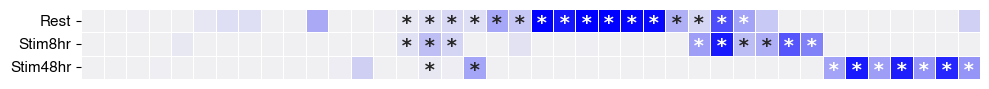

In [29]:
fig, ax = plt.subplots(figsize=(10, 1))
cmap = sns.color_palette("light:b", as_cmap=True)
annot_kws = {"fontsize": 14, 'ha': 'center', 'va': 'center_baseline', 'weight': 'bold', 'fontfamily': 'monospace'}
sns.heatmap(condition_specificity.loc[cluster_order, ['rest_enrich', 'stim8hr_enrich', 'stim48hr_enrich']].T, vmin=1, vmax=2.5, ax=ax,
            annot=fail_mask_annot.loc[cluster_order].T, fmt='', cmap=cmap, cbar=False, linewidth=0.5, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'], xticklabels=False, annot_kws=annot_kws)
ax.set_yticklabels(['Rest', 'Stim8hr', 'Stim48hr'], fontsize=11, rotation=0)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('./results/condition_specificity_nolabel.pdf', dpi=600)

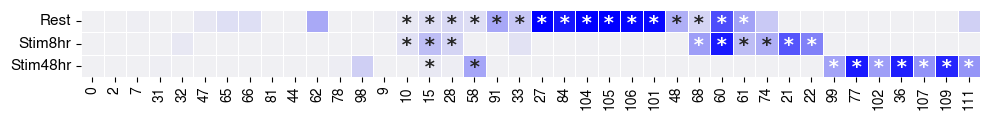

In [30]:
fig, ax = plt.subplots(figsize=(10, 1.3))
cmap = sns.color_palette("light:b", as_cmap=True)
annot_kws = {"fontsize": 14, 'ha': 'center', 'va': 'center_baseline', 'weight': 'bold', 'fontfamily': 'monospace'}
sns.heatmap(condition_specificity.loc[cluster_order, ['rest_enrich', 'stim8hr_enrich', 'stim48hr_enrich']].T, vmin=1, vmax=2.5, ax=ax,
            annot=fail_mask_annot.loc[cluster_order].T, fmt='', linewidth=0.5, cmap=cmap, cbar=False, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'], annot_kws=annot_kws)
ax.set_yticklabels(['Rest', 'Stim8hr', 'Stim48hr'], fontsize=11, rotation=0)
ax.set_xticklabels(cluster_order)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('./results/condition_specificity_withlabel.pdf', dpi=600)

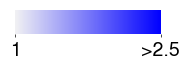

In [3]:
cmap = sns.color_palette("light:b", as_cmap=True)
norm = mpl.colors.Normalize(vmin=1, vmax=2.5)

# Create small horizontal figure
fig, ax = plt.subplots(figsize=(2, 0.8))

# Draw the colorbar
cb = mpl.colorbar.ColorbarBase(
    ax,
    cmap=cmap,
    norm=norm,
    orientation='horizontal'
)

# Remove outline and tidy style
cb.outline.set_visible(False)
cb.ax.tick_params(labelsize=14, width=0.5, length=2)
cb.set_ticks([1, 2.5])
cb.set_ticklabels(['1', '>2.5'])

# Add "Correlation" label on the left
#ax.text(-0.1, 0.5, "Enrichment", fontsize=16, va='center', ha='right', transform=ax.transAxes)

# Adjust layout
plt.subplots_adjust(left=0.25, right=0.95, top=0.7, bottom=0.45)
plt.tight_layout()
plt.savefig('./results/colorbar_condition_specificity.png', dpi=600)

In [ ]:
condition_specificity

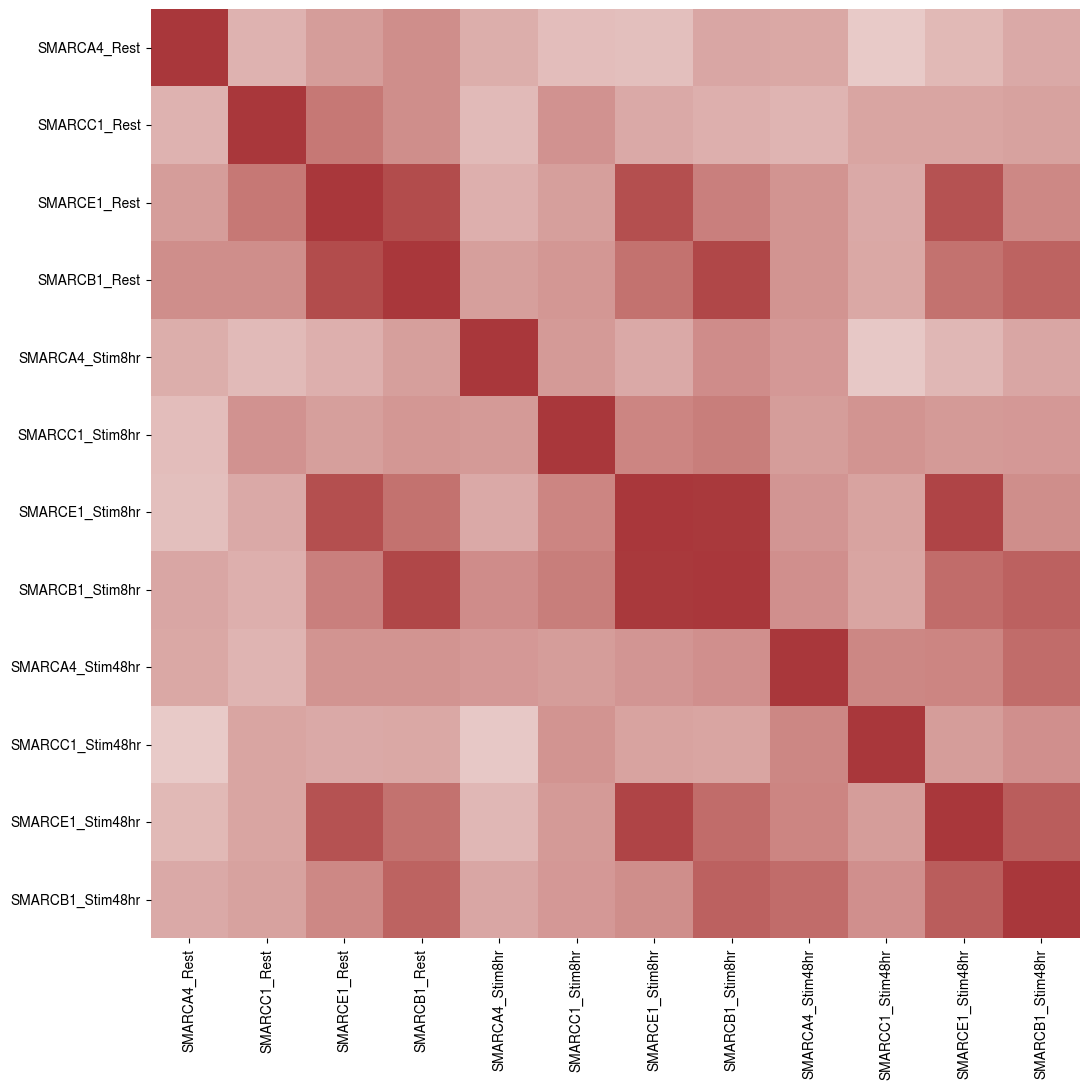

In [152]:
cl = 81
thres = 0.6
plt.figure(figsize=(11, 11))
genelist = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist()
genelist = set(genelist) & set(adata_de.obs.target_contrast_gene_name_corrected.value_counts()[adata_de.obs.target_contrast_gene_name_corrected.value_counts()==3].index)
regulator = list(genelist)
corr_mtx = corr_compute(adata_de, regulator)

# Reorder regulator based on hierarchical clustering of regulators in main conditions
# For each cluster, get regulator member list
main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
regulator_main_condition = [item+'_'+main_condition for item in regulator]

# Get reordered downstream genes based on DE effect of main condition
clustermap = sns.clustermap(corr_mtx.loc[regulator_main_condition, regulator_main_condition], 
                            method='average', 
                            metric='euclidean')
xticklabel_indices = clustermap.dendrogram_col.reordered_ind
plt.close(clustermap.fig)
regulator_reordered = np.array(regulator)[xticklabel_indices]

target_names_rest = adata_de[adata_de.obs['culture_condition']=='Rest'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_rest)
regulator_rest = regulator_reordered[isin_mask]
regulator_rest = [item+'_Rest' for item in regulator_rest]
target_names_stim8hr = adata_de[adata_de.obs['culture_condition']=='Stim8hr'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim8hr)
regulator_stim8hr = regulator_reordered[isin_mask]
regulator_stim8hr = [item+'_Stim8hr' for item in regulator_stim8hr]
target_names_stim48hr = adata_de[adata_de.obs['culture_condition']=='Stim48hr'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim48hr)
regulator_stim48hr = regulator_reordered[isin_mask]
regulator_stim48hr = [item+'_Stim48hr' for item in regulator_stim48hr]
regulator_all = np.concatenate([regulator_rest, regulator_stim8hr, regulator_stim48hr])

sns.heatmap(corr_mtx.loc[regulator_all, regulator_all], vmin=-thres, vmax=thres, cmap='vlag', cbar=False)#, xticklabels=False, yticklabels=False)
#plt.xlabel('Perturbed genes (n='+str(len(genelist))+')', fontsize=32, labelpad=5)
#plt.ylabel('Perturbed genes (n='+str(len(genelist))+')', fontsize=32, labelpad=5)
plt.tight_layout()
#plt.savefig('./results/cluster'+str(cl)+'.png')

In [98]:
print(adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist())

['ENSG00000138074', 'ENSG00000196396', 'ENSG00000164080', 'ENSG00000121940', 'ENSG00000078596', 'ENSG00000156958', 'ENSG00000167136', 'ENSG00000134809', 'ENSG00000173193', 'ENSG00000148175', 'ENSG00000146918', 'ENSG00000166669', 'ENSG00000149269', 'ENSG00000100985', 'ENSG00000182287', 'ENSG00000164329', 'ENSG00000168038', 'ENSG00000198513', 'ENSG00000156253', 'ENSG00000144535', 'ENSG00000147669', 'ENSG00000170275', 'ENSG00000204252', 'ENSG00000119899', 'ENSG00000167604', 'ENSG00000179151', 'ENSG00000116001', 'ENSG00000099139', 'ENSG00000154165', 'ENSG00000173674', 'ENSG00000125534', 'ENSG00000204498', 'ENSG00000151687', 'ENSG00000133246', 'ENSG00000127152', 'ENSG00000135426', 'ENSG00000140543', 'ENSG00000109771', 'ENSG00000131697', 'ENSG00000115306', 'ENSG00000172086', 'ENSG00000095015', 'ENSG00000205758', 'ENSG00000145782', 'ENSG00000179388', 'ENSG00000100453', 'ENSG00000116478', 'ENSG00000163006', 'ENSG00000100330', 'ENSG00000144306']


In [161]:
genelist = ['ATL1', 'CD3G']

In [164]:
cond_mask = adata_de.obs['culture_condition']=='Stim48hr'
gene1_zscore = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[0]),:].layers['masked_zscore'][0].copy()
gene1_padj = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[0]),:].layers['adj_p_value'][0].copy()
gene2_zscore = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[1]),:].layers['masked_zscore'][0].copy()
gene2_padj = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[1]),:].layers['adj_p_value'][0].copy()

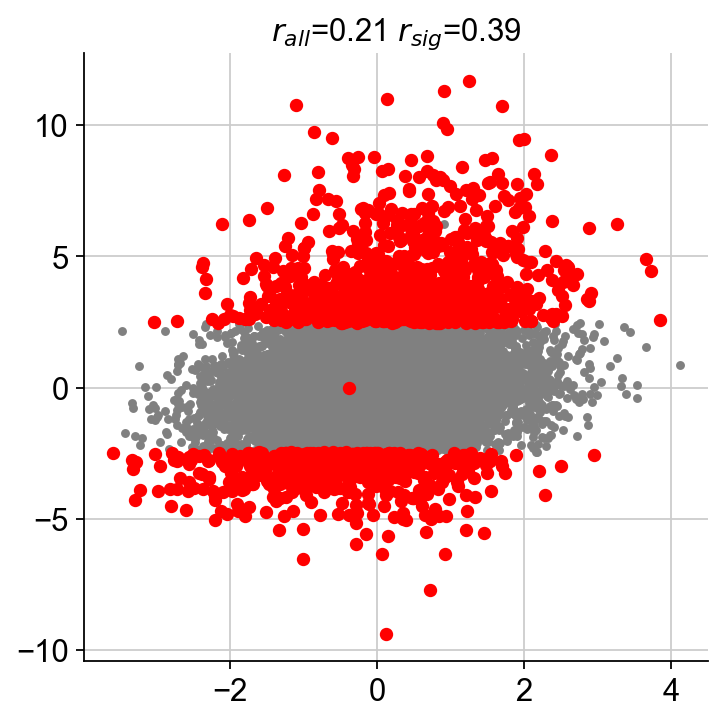

In [165]:
fig, ax = plt.subplots(figsize=(5,5))
sig_mask = (gene1_padj<0.1)|(gene2_padj<0.1)
ax.plot(gene1_zscore[~sig_mask], gene2_zscore[~sig_mask], '.', color='gray')
ax.plot(gene1_zscore[sig_mask], gene2_zscore[sig_mask], '.', color='red', markersize=10)
result_all = pearsonr(gene1_zscore, gene2_zscore)
result_sig = pearsonr(gene1_zscore[sig_mask], gene2_zscore[sig_mask])
ax.set_title(r'$r_{all}$='+f'{result_all.statistic:.2f} '+r'$r_{sig}$='+f'{result_sig.statistic:.2f}')
sns.despine()

In [45]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected.isin(['STAT5B', 'IL4R', 'STAT3', 'RASA2', 'PPA2','CD3D'])].obs.sort_values(by='target_contrast_gene_name_corrected')

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000167286_Stim8hr,CD3D,Stim8hr,ENSG00000167286,436,185.0,ENSG00000167286,CD3D,22
ENSG00000167286_Stim48hr,CD3D,Stim48hr,ENSG00000167286,634,85.0,ENSG00000167286,CD3D,99
ENSG00000077238_Stim8hr,IL4R,Stim8hr,ENSG00000077238,222,903.0,ENSG00000077238,IL4R,88
ENSG00000077238_Stim48hr,IL4R,Stim48hr,ENSG00000077238,476,911.0,ENSG00000077238,IL4R,85
ENSG00000138777_Rest,PPA2,Rest,ENSG00000138777,140,176.0,ENSG00000138777,PPA2,48
ENSG00000138777_Stim8hr,PPA2,Stim8hr,ENSG00000138777,511,164.0,ENSG00000138777,PPA2,-1
ENSG00000155903_Stim48hr,RASA2,Stim48hr,ENSG00000155903,319,420.0,ENSG00000155903,RASA2,88
ENSG00000155903_Stim8hr,RASA2,Stim8hr,ENSG00000155903,385,471.0,ENSG00000155903,RASA2,80
ENSG00000155903_Rest,RASA2,Rest,ENSG00000155903,630,416.0,ENSG00000155903,RASA2,75
ENSG00000168610_Rest,STAT3,Rest,ENSG00000168610,241,239.0,ENSG00000168610,STAT3,106


In [12]:
adata_final[adata_final.obs.hdbscan==99].obs.sort_values(by='target_contrast_gene_name_corrected')

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000157426_Stim48hr,AASDH,Stim48hr,ENSG00000157426,643,515.0,ENSG00000157426,AASDH,99
ENSG00000189007_Stim48hr,ADAT2,Stim48hr,ENSG00000189007,677,333.0,ENSG00000189007,ADAT2,99
ENSG00000213638_Stim48hr,ADAT3,Stim48hr,ENSG00000213638,294,292.0,ENSG00000213638,ADAT3,99
ENSG00000168876_Stim48hr,ANKRD49,Stim48hr,ENSG00000168876,506,133.0,ENSG00000168876,ANKRD49,99
ENSG00000157999_Stim48hr,ANKRD61,Stim48hr,ENSG00000157999,586,1001.0,ENSG00000157999,ANKRD61,99
...,...,...,...,...,...,...,...,...
ENSG00000115085_Stim48hr,ZAP70,Stim48hr,ENSG00000115085,512,52.0,ENSG00000115085,ZAP70,99
ENSG00000135482_Stim48hr,ZC3H10,Stim48hr,ENSG00000135482,392,892.0,ENSG00000135482,ZC3H10,99
ENSG00000183779_Stim48hr,ZNF703,Stim48hr,ENSG00000183779,303,63.0,ENSG00000183779,ZNF703,99
ENSG00000152475_Stim48hr,ZNF837,Stim48hr,ENSG00000152475,570,389.0,ENSG00000152475,ZNF837,99


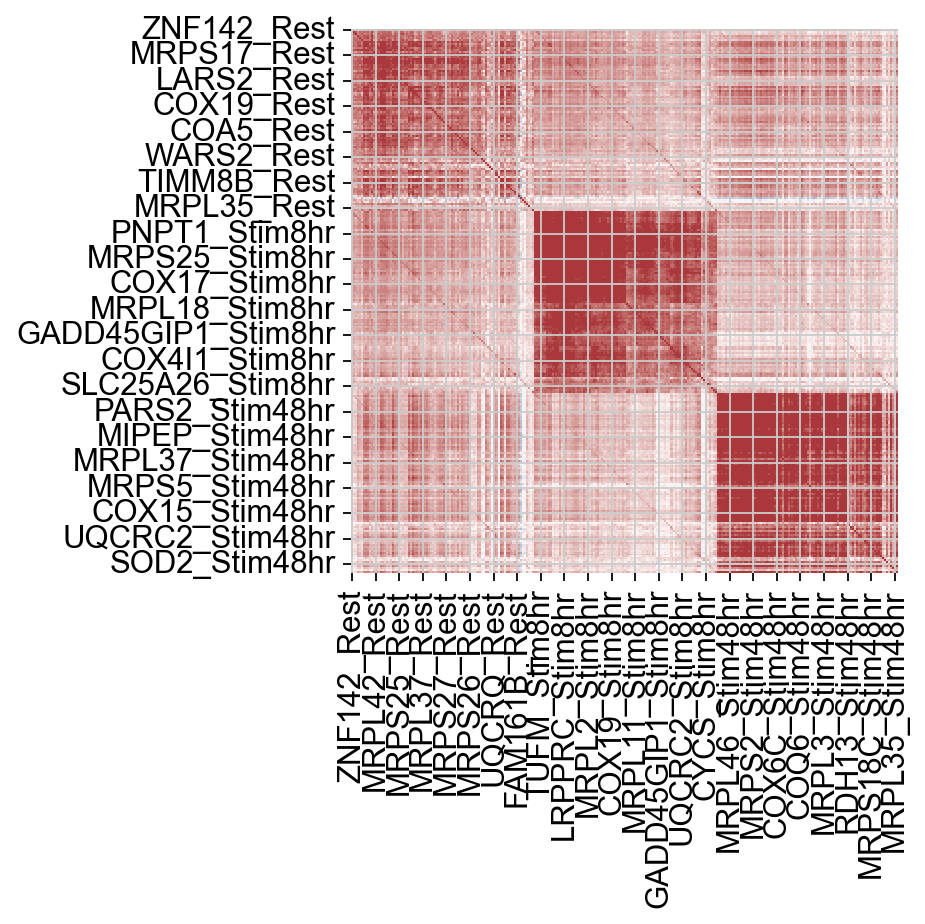

In [113]:
cl = 48
thres = 0.4
plt.figure(figsize=(6, 6))
genelist = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)

# Reorder regulator based on hierarchical clustering of regulators in main conditions
# For each cluster, get regulator member list
regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_gene_name_corrected'].unique().tolist()
main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
regulator_main_condition = [item+'_'+main_condition for item in regulator]

# Get reordered downstream genes based on DE effect of main condition
clustermap = sns.clustermap(corr_mtx.loc[regulator_main_condition, regulator_main_condition], 
                            method='average', 
                            metric='euclidean')
xticklabel_indices = clustermap.dendrogram_col.reordered_ind
plt.close(clustermap.fig)
regulator_reordered = np.array(regulator)[xticklabel_indices]

target_names_rest = adata_de[adata_de.obs['culture_condition']=='Rest'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_rest)
regulator_rest = regulator_reordered[isin_mask]
regulator_rest = [item+'_Rest' for item in regulator_rest]
target_names_stim8hr = adata_de[adata_de.obs['culture_condition']=='Stim8hr'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim8hr)
regulator_stim8hr = regulator_reordered[isin_mask]
regulator_stim8hr = [item+'_Stim8hr' for item in regulator_stim8hr]
target_names_stim48hr = adata_de[adata_de.obs['culture_condition']=='Stim48hr'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim48hr)
regulator_stim48hr = regulator_reordered[isin_mask]
regulator_stim48hr = [item+'_Stim48hr' for item in regulator_stim48hr]
regulator_all = np.concatenate([regulator_rest, regulator_stim8hr, regulator_stim48hr])

sns.heatmap(corr_mtx.loc[regulator_all, regulator_all], vmin=-thres, vmax=thres, cmap='vlag', cbar=False)#, xticklabels=False, yticklabels=False)
#plt.xlabel('Perturbed genes (n='+str(len(genelist))+')', fontsize=32, labelpad=5)
#plt.ylabel('Perturbed genes (n='+str(len(genelist))+')', fontsize=32, labelpad=5)
plt.tight_layout()
#plt.savefig('./results/cluster'+str(cl)+'.png')

In [105]:
regulator

['SLC24A1',
 'ARID5B',
 'INTS13',
 'INTS15',
 'FGFR1OP2',
 'INTS14',
 'INTS10',
 'EBF3']

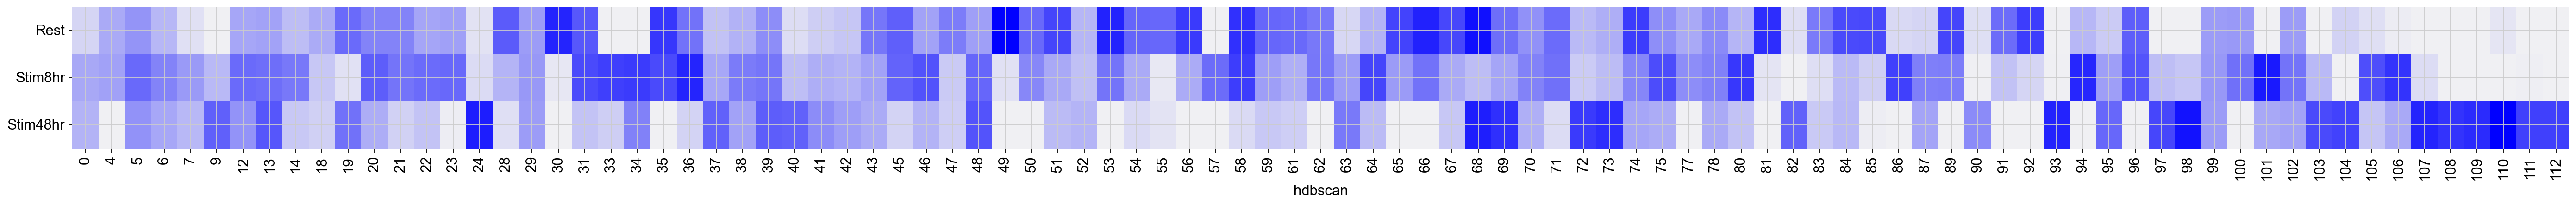

In [40]:
fig, ax = plt.subplots(figsize=(35, 3))
sns.heatmap(condition_specificity.iloc[:,1:].T, vmin=0, vmax=1, ax=ax, cmap=sns.color_palette("light:b", as_cmap=True), cbar=False)
ax.set_yticklabels(['Rest', 'Stim8hr', 'Stim48hr'], rotation=0)
plt.tight_layout()

In [120]:
hdbscan_order = np.array([0, 1, 2, 6, 7, 
                          14, 13, 25, 84, 
                          15, 
                          36, 60, 67, 
                          40, 53, 
                          43, 
                          97, 108,
                          39, 45, 55, 68, 78, 86, 92, # unknown, not specific
                          56,
                          73, 87, 94, 58, # cell cycle upstream
                          65, # unknown, stim8hr
                          61, 66, 74, 88, # unknown, rest & stim8hr
                          72, 90, 96, # unknown, rest
                          54, # stim48hr
                          98, # stim48hr
                          69, # stim48hr
                          107,
                          37, 109, 
                          77, 83, 102, 104]) # unknown, stim48hr

In [32]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected=='TSC1'].obs.sort_values(by='target_contrast_gene_name_corrected')

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000165699_Rest,TSC1,Rest,ENSG00000165699,325,492.0,ENSG00000165699,TSC1,101
ENSG00000165699_Stim8hr,TSC1,Stim8hr,ENSG00000165699,440,371.0,ENSG00000165699,TSC1,21
ENSG00000165699_Stim48hr,TSC1,Stim48hr,ENSG00000165699,462,309.0,ENSG00000165699,TSC1,77


In [33]:
print(adata_final[adata_final.obs.hdbscan==101].obs.target_contrast_gene_name.tolist())

['GNPDA2', 'NCBP3', 'TNFRSF10B', 'GJC1', 'RMND5A', 'FAM208A', 'CCL5', 'ANP32B', 'TBCA', 'CCNF', 'A2M', 'TSC2', 'YEATS2', 'EDRF1', 'DNAJA3', 'MORC2', 'NAA40', 'C8orf33', 'MAEA', 'C11orf54', 'RPS6KB1', 'PUDP', 'GPS2', 'FBXO3', 'DMRTA2', 'CYB561D2', 'PUM1', 'KCNA2', 'DBF4', 'TSC1', 'TOP2B', 'PPHLN1', 'COX20', 'IWS1', 'PPP1R2', 'SMARCA5', 'SESTD1', 'MED15', 'HP1BP3', 'MOSMO', 'NASP', 'TRIP12', 'EWSR1', 'TNK1', 'MOSPD1', 'ABHD14A', 'BPTF', 'SLC25A22', 'CPOX', 'PPM1D', 'HUWE1', 'WDR48', 'PPP1R3B', 'ADO', 'OTUD1', 'KCTD21', 'LIG1', 'AASDH']


In [21]:
cl = 49
gene_id_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
corr_all = pd.DataFrame(adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].layers['masked_zscore'].T,
                       columns=adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].obs_names).corr()
corr_all = corr_all.reset_index()
corr_all = corr_all.rename(columns={'index': 'Index_ID'})
corr_all_long = pd.melt(corr_all, 
                        id_vars=['Index_ID'],
                        var_name='Column_ID',
                        value_name='Correlation_Value'
                       )
corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]

corr_across_condition = corr_all_long[corr_all_long.perturbation_1_condition!=corr_all_long.perturbation_2_condition].Correlation_Value.median()

corr_rest = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value.median()
corr_stim8hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value.median()
corr_stim48hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value.median()

corr_max = np.max([corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition])

corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition,\
(corr_rest - corr_across_condition)/corr_max,\
(corr_stim8hr - corr_across_condition)/corr_max,\
(corr_stim48hr - corr_across_condition)/corr_max

(0.18395589694459183,
 0.006430839671764169,
 -0.011248680690649257,
 -0.005330064813342776,
 1.0289746885088886,
 0.06393328336002935,
 -0.032174102464838025)

In [22]:
cl = 0
gene_id_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
corr_all = pd.DataFrame(adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].layers['masked_zscore'].T,
                       columns=adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].obs_names).corr()
corr_all = corr_all.reset_index()
corr_all = corr_all.rename(columns={'index': 'Index_ID'})
corr_all_long = pd.melt(corr_all, 
                        id_vars=['Index_ID'],
                        var_name='Column_ID',
                        value_name='Correlation_Value'
                       )
corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]

corr_across_condition = corr_all_long[corr_all_long.perturbation_1_condition!=corr_all_long.perturbation_2_condition].Correlation_Value.median()

corr_rest = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value.median()
corr_stim8hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value.median()
corr_stim48hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value.median()

corr_max = np.max([corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition])

corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition,\
(corr_rest - corr_across_condition)/corr_max,\
(corr_stim8hr - corr_across_condition)/corr_max,\
(corr_stim48hr - corr_across_condition)/corr_max

(0.37982428772240495,
 0.4672924528695795,
 0.44453184142213575,
 0.3254618580753062,
 0.11633491898545859,
 0.3035156975536645,
 0.2548082739527184)

In [23]:
cl = 5
gene_id_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
corr_all = pd.DataFrame(adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].layers['masked_zscore'].T,
                       columns=adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].obs_names).corr()
corr_all = corr_all.reset_index()
corr_all = corr_all.rename(columns={'index': 'Index_ID'})
corr_all_long = pd.melt(corr_all, 
                        id_vars=['Index_ID'],
                        var_name='Column_ID',
                        value_name='Correlation_Value'
                       )
corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]

corr_across_condition = corr_all_long[corr_all_long.perturbation_1_condition!=corr_all_long.perturbation_2_condition].Correlation_Value.median()

corr_rest = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value.median()
corr_stim8hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value.median()
corr_stim48hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value.median()

corr_max = np.max([corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition])

corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition,\
(corr_rest - corr_across_condition)/corr_max,\
(corr_stim8hr - corr_across_condition)/corr_max,\
(corr_stim48hr - corr_across_condition)/corr_max

(0.28008058488579707,
 0.34037159779136544,
 0.2830389071207588,
 0.14882457080475586,
 0.3856256366064246,
 0.5627585504476212,
 0.3943170851707524)

In [24]:
cl = 13
gene_id_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
corr_all = pd.DataFrame(adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].layers['masked_zscore'].T,
                       columns=adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].obs_names).corr()
corr_all = corr_all.reset_index()
corr_all = corr_all.rename(columns={'index': 'Index_ID'})
corr_all_long = pd.melt(corr_all, 
                        id_vars=['Index_ID'],
                        var_name='Column_ID',
                        value_name='Correlation_Value'
                       )
corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]

corr_across_condition = corr_all_long[corr_all_long.perturbation_1_condition!=corr_all_long.perturbation_2_condition].Correlation_Value.median()

corr_rest = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value.median()
corr_stim8hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value.median()
corr_stim48hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value.median()

corr_max = np.max([corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition])

corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition,\
(corr_rest - corr_across_condition)/corr_max,\
(corr_stim8hr - corr_across_condition)/corr_max,\
(corr_stim48hr - corr_across_condition)/corr_max

(0.30221506503252626,
 0.3976965571760571,
 0.44112596619722627,
 0.15850405307682894,
 0.3257822548841854,
 0.5422317488159059,
 0.6406830129651397)

In [20]:
cl = 30
gene_id_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
corr_all = pd.DataFrame(adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].layers['masked_zscore'].T,
                       columns=adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].obs_names).corr()
corr_all = corr_all.reset_index()
corr_all = corr_all.rename(columns={'index': 'Index_ID'})
corr_all_long = pd.melt(corr_all, 
                        id_vars=['Index_ID'],
                        var_name='Column_ID',
                        value_name='Correlation_Value'
                       )
corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]

corr_across_condition = corr_all_long[corr_all_long.perturbation_1_condition!=corr_all_long.perturbation_2_condition].Correlation_Value.median()

corr_rest = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value.median()
corr_stim8hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value.median()
corr_stim48hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value.median()

corr_max = np.max([corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition])

corr_rest, corr_stim8hr, corr_stim48hr, corr_across_condition,\
(corr_rest - corr_across_condition)/corr_across_condition,\
(corr_stim8hr - corr_across_condition)/corr_across_condition,\
(corr_stim48hr - corr_across_condition)/corr_across_condition

(0.3385712235653755,
 0.06513158505814037,
 0.034751644527588055,
 0.05060617180185886,
 5.690314866949471,
 0.28702849354331056,
 -0.3132923655309655)

In [23]:
condition_specificity

,cluster_gene_size,hdbscan_corr_rest_over_across_condition,hdbscan_corr_stim8hr_over_across_condition,hdbscan_corr_stim48hr_over_across_condition
hdbscan,,,,
0,8,0.092219,0.313111,0.263539
4,9,0.246074,0.327720,-0.032563
5,7,0.381060,0.544103,0.337025
6,36,0.253276,0.429480,0.312972
7,11,0.179153,0.317840,0.247141
9,5,0.281590,0.334746,0.129971
12,6,0.349313,0.540194,0.332986
13,57,0.326802,0.526268,0.622065
14,49,0.228539,0.495505,0.184489


In [ ]:
condition_specificity

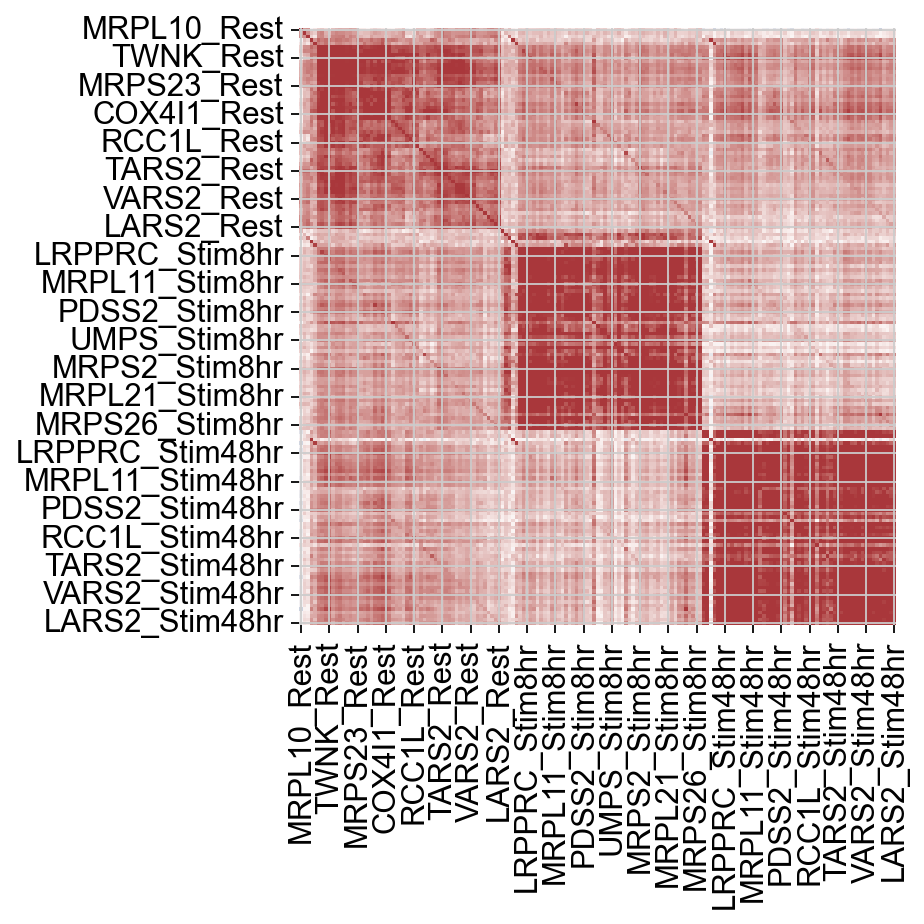

In [19]:
cl = 13
thres = 0.4
plt.figure(figsize=(6, 6))
genelist = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)

# Reorder regulator based on hierarchical clustering of regulators in main conditions
# For each cluster, get regulator member list
regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_gene_name_corrected'].unique().tolist()
main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
regulator_main_condition = [item+'_'+main_condition for item in regulator]

# Get reordered downstream genes based on DE effect of main condition
clustermap = sns.clustermap(corr_mtx.loc[regulator_main_condition, regulator_main_condition], 
                            method='average', 
                            metric='euclidean')
xticklabel_indices = clustermap.dendrogram_col.reordered_ind
plt.close(clustermap.fig)
regulator_reordered = np.array(regulator)[xticklabel_indices]

target_names_rest = adata_de[adata_de.obs['culture_condition']=='Rest'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_rest)
regulator_rest = regulator_reordered[isin_mask]
regulator_rest = [item+'_Rest' for item in regulator_rest]
target_names_stim8hr = adata_de[adata_de.obs['culture_condition']=='Stim8hr'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim8hr)
regulator_stim8hr = regulator_reordered[isin_mask]
regulator_stim8hr = [item+'_Stim8hr' for item in regulator_stim8hr]
target_names_stim48hr = adata_de[adata_de.obs['culture_condition']=='Stim48hr'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim48hr)
regulator_stim48hr = regulator_reordered[isin_mask]
regulator_stim48hr = [item+'_Stim48hr' for item in regulator_stim48hr]
regulator_all = np.concatenate([regulator_rest, regulator_stim8hr, regulator_stim48hr])

sns.heatmap(corr_mtx.loc[regulator_all, regulator_all], vmin=-thres, vmax=thres, cmap='vlag', cbar=False)#, xticklabels=False, yticklabels=False)
#plt.xlabel('Perturbed genes (n='+str(len(genelist))+')', fontsize=32, labelpad=5)
#plt.ylabel('Perturbed genes (n='+str(len(genelist))+')', fontsize=32, labelpad=5)
plt.tight_layout()
#plt.savefig('./results/cluster'+str(cl)+'.png')

In [180]:
cl = 0
gene_id_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
corr_all = pd.DataFrame(adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].layers['zscore'].T,
                       columns=adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].obs_names).corr()
corr_all = corr_all.reset_index()
corr_all = corr_all.rename(columns={'index': 'Index_ID'})
corr_all_long = pd.melt(corr_all, 
                        id_vars=['Index_ID'],
                        var_name='Column_ID',
                        value_name='Correlation_Value'
                       )
corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]

corr_across_condition_mean = corr_all_long[corr_all_long.perturbation_1_condition!=corr_all_long.perturbation_2_condition].Correlation_Value.mean()

corr_rest_mean = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value.mean()
corr_stim8hr_mean = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value.mean()
corr_stim48hr_mean = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value.mean()

In [181]:
corr_across_condition_mean

0.27617561369139526

In [182]:
corr_rest_mean, corr_stim8hr_mean, corr_stim48hr_mean

(0.3772636894623014, 0.41080414908189233, 0.26279878782443)

In [183]:
regulator_main_condition

['CASC3_Stim8hr',
 'SMG7_Stim8hr',
 'SMG9_Stim8hr',
 'SRR_Stim8hr',
 'XRN1_Stim8hr',
 'UPF2_Stim8hr',
 'SMG1_Stim8hr',
 'SMG8_Stim8hr',
 'TMEM79_Stim8hr']

In [127]:
regulator_reordered

array(['PIM1', 'GATAD1', 'GATAD1', 'PHF12', 'PHF12', 'PHF12', 'SIN3B',
       'SIN3B', 'SIN3B'], dtype='<U6')

In [126]:
regulator_rest

['PIM1_Rest',
 'GATAD1_Rest',
 'GATAD1_Rest',
 'PHF12_Rest',
 'PHF12_Rest',
 'PHF12_Rest',
 'SIN3B_Rest',
 'SIN3B_Rest',
 'SIN3B_Rest']

In [125]:
regulator_all

array(['PIM1_Rest', 'GATAD1_Rest', 'GATAD1_Rest', 'PHF12_Rest',
       'PHF12_Rest', 'PHF12_Rest', 'SIN3B_Rest', 'SIN3B_Rest',
       'SIN3B_Rest', 'PIM1_Stim8hr', 'GATAD1_Stim8hr', 'GATAD1_Stim8hr',
       'PHF12_Stim8hr', 'PHF12_Stim8hr', 'PHF12_Stim8hr', 'SIN3B_Stim8hr',
       'SIN3B_Stim8hr', 'SIN3B_Stim8hr', 'GATAD1_Stim48hr',
       'GATAD1_Stim48hr', 'PHF12_Stim48hr', 'PHF12_Stim48hr',
       'PHF12_Stim48hr', 'SIN3B_Stim48hr', 'SIN3B_Stim48hr',
       'SIN3B_Stim48hr'], dtype='<U15')

In [124]:
corr_mtx

,GATAD1_Rest,PHF12_Rest,PIM1_Rest,SIN3B_Rest,GATAD1_Stim8hr,PHF12_Stim8hr,PIM1_Stim8hr,SIN3B_Stim8hr,GATAD1_Stim48hr,PHF12_Stim48hr,SIN3B_Stim48hr
GATAD1_Rest,1.000000,0.261294,0.353681,0.459397,0.217486,0.228700,0.126759,0.314830,0.257321,0.269159,0.389063
PHF12_Rest,0.261294,1.000000,0.349827,0.504099,0.251890,0.337057,0.263746,0.394425,0.215424,0.336632,0.361644
PIM1_Rest,0.353681,0.349827,1.000000,0.468329,0.186534,0.240274,0.337182,0.297659,0.196700,0.243432,0.340756
SIN3B_Rest,0.459397,0.504099,0.468329,1.000000,0.345852,0.368852,0.330362,0.596259,0.334250,0.411513,0.606398
GATAD1_Stim8hr,0.217486,0.251890,0.186534,0.345852,1.000000,0.377575,0.311144,0.470233,0.215212,0.238878,0.321314
PHF12_Stim8hr,0.228700,0.337057,0.240274,0.368852,0.377575,1.000000,0.363334,0.511770,0.207884,0.322089,0.358357
PIM1_Stim8hr,0.126759,0.263746,0.337182,0.330362,0.311144,0.363334,1.000000,0.392735,0.129980,0.207301,0.277003
SIN3B_Stim8hr,0.314830,0.394425,0.297659,0.596259,0.470233,0.511770,0.392735,1.000000,0.347026,0.406505,0.592103
GATAD1_Stim48hr,0.257321,0.215424,0.196700,0.334250,0.215212,0.207884,0.129980,0.347026,1.000000,0.339429,0.472985
PHF12_Stim48hr,0.269159,0.336632,0.243432,0.411513,0.238878,0.322089,0.207301,0.406505,0.339429,1.000000,0.515864
